In [1]:
import cv2, os, sys, pickle, argparse, shutil, inspect, random, time

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(666666)

from relocal.point_feat import *
from reloc_pipeline.util_func import *

## Configuration
set the `7Scenes` dataset directory and test sequence name in `seq_name`.

In [4]:
# Config ---------------------------------------------------------------------------------------------------------------
dev_id = 0                                # cuda device id

top_k = 10                                # top k vlad reterival images
repro_thres = 0.75                        # pnp reproject threshold in pixels

# dataset
base_dir = '/mnt/Exp_1/7scenes/'
seq_name = 'heads'

# network
checkpoint_path = './data/seven_scene_model.pth.tar'

## Load network

In [13]:
import core_dl.module_util as dl_util
from relocal.corres_net import Corres2D3DNet
from relocal.vlad_encoder import VLADEncoder

torch.cuda.set_device(dev_id)
out_dim = (48, 64)
frame_dim = (192, 256)

# load network
with torch.cuda.device(dev_id):
    checkpoint = dl_util.load_checkpoints(checkpoint_path)
    model = Corres2D3DNet(out_global_feat=512)
    model.load_state_dict(checkpoint['net_instance'])
    model.cuda()

# vlad database for image reterival
vlad_db = VLADEncoder(checkpoint_path='data/netvlad_vgg16.tar', dev_id=dev_id)

In [14]:
from relocal_data.seven_scene.seven_scene_manual_dataset import SevenSceneManualDataset

# read test frames from binary file
test_frames_path = os.path.join(base_dir, '%s/test_frames.bin' % seq_name)
with open(test_frames_path, 'rb') as f:
    test_frames = pickle.load(f, encoding='latin1')
print('Total test frames: %d' % len(test_frames))

# read train frames from binary file, sampled by skipping 10 frames
train_frames_path = os.path.join(base_dir, '%s/train_frames.bin' % seq_name)
with open(train_frames_path, 'rb') as f:
    sampled_train_frames = pickle.load(f, encoding='latin1')[::10]
print('Total train frames: %d' % len(sampled_train_frames))

# dataset pre-processing func
transform_func = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

Total test frames: 1000
Total train frames: 100


### Cache VLAD feature for query image retrieval

In [19]:
from banet_track.ba_module import x_2d_coords_torch, batched_pi_inv, batched_transpose, batched_inv_pose, batched_pi

# load dataset
scene_set = SevenSceneManualDataset(base_dir=base_dir,
                                    seq_frame_list=sampled_train_frames,
                                    transform=transform_func,
                                    fill_depth_holes=False,
                                    output_dim=(3, 192, 256))
scene_loader = DataLoader(scene_set, batch_size=1, num_workers=0, shuffle=False)

# add train frames to vlad database
x_2d_scene = x_2d_coords_torch(5, frame_dim[0], frame_dim[1]).cuda()
x_2d_scene = x_2d_scene.view(5, -1, 2)

retrival_scene_feats = []
model.eval()
for sample_dict in tqdm(scene_loader):
    with torch.cuda.device(dev_id):
        with torch.no_grad():
            scene_rgb = sample_dict['frames_img'].cuda()
            scene_depth = sample_dict['frames_depth'].cuda()
            scene_K = sample_dict['frames_K'].cuda()
            scene_Tcw = sample_dict['frames_Tcw']
            scene_ori_rgb = sample_dict['frames_ori_img'].cuda()
            scene_input, scene_ori_rgb, X_world, scene_valid_mask, scene_center, rand_R = \
                preprocess_scene(x_2d_scene, scene_rgb, scene_depth, scene_K, scene_Tcw, scene_ori_rgb)
            
            cur_scene_input = scene_input[0, :, :3, ...]
            retrival_scene_feat = vlad_db.forward(cur_scene_input)
            retrival_scene_feats += [feat.unsqueeze(0).cpu().numpy() for feat in retrival_scene_feat]

100%|██████████| 20/20 [00:04<00:00,  5.73it/s]


## Query a single frame and visualize the scene coordinates 

In [36]:
# visualize one frame 
from sklearn.metrics.pairwise import cosine_similarity as cos_sim
from evaluator.basic_metric import rel_rot_angle, rel_distance
import core_3dv.camera_operator as cam_opt

x_2d = x_2d_coords_torch(top_k, frame_dim[0], frame_dim[1]).cuda()
x_2d = x_2d.view(top_k, -1, 2)
# pnp_x_2d = cam_opt.x_2d_coords(h=out_dim[0], w=out_dim[1])

q_idx = 500
# for q_idx in tqdm(range(0, len(test_frames), 1)):

# Step 1: find top-k neighbor frames of a given query frame ----------------------------------------------
q_frame = test_frames[q_idx]
q_set = SevenSceneManualDataset(base_dir=base_dir,
                                seq_frame_list=[q_frame],
                                transform=transform_func,
                                fill_depth_holes=False,
                                output_dim=(3, 192, 256),
                                nsample_per_group=1)
q_loader = DataLoader(q_set, batch_size=1, num_workers=0, shuffle=False)

with torch.cuda.device(dev_id):
    with torch.no_grad():
        sample_dict = next(iter(q_loader))
        query_img = sample_dict['frames_img']
        query_ori_img = sample_dict['frames_ori_img']
        query_depth = sample_dict['frames_depth'].cuda()
        query_Tcw = sample_dict['frames_Tcw']
        ori_query_K = sample_dict['frames_K'].clone().cuda()

        query_img = query_img.squeeze(1)
        query_ori_img = query_ori_img.squeeze(1)
        query_depth = query_depth.squeeze(1)
        query_Tcw = query_Tcw.squeeze(1)
        ori_query_K = ori_query_K.squeeze(1)

        query_img, query_X_world, valid_mask, query_ori_img, scene_center, query_Tcw, query_K, rand_R = \
            preprocess_query(query_img, query_depth, query_ori_img, query_Tcw, ori_query_K, scene_center, rand_R, out_dim)
        seq_feat = vlad_db.forward(query_img)

# determine top-K
n_feat = seq_feat.shape[1]

scene_feats = retrival_scene_feats
n_scenes = len(scene_feats)

dist = [cos_sim(seq_feat, scene_feats[idx]) for idx in range(n_scenes)]
dist = np.asarray(dist).ravel()
sorted_indices = np.argsort((1-dist))

top_k_frames = [sampled_train_frames[idx] for idx in sorted_indices[:10]]

# Step 2: build the scene representation ---------------------------------------------------------------
scene_set = SevenSceneManualDataset(base_dir=base_dir,
                                    seq_frame_list=top_k_frames,
                                    transform=transform_func,
                                    fill_depth_holes=False,
                                    output_dim=(3, 192, 256),
                                    nsample_per_group=10)
scene_loader = DataLoader(scene_set, batch_size=1, num_workers=0, shuffle=False)

with torch.cuda.device(dev_id):
    with torch.no_grad():
        sample_dict = next(iter(scene_loader))
        scene_rgb = sample_dict['frames_img'].cuda()
        scene_depth = sample_dict['frames_depth'].cuda()
        scene_K = sample_dict['frames_K'].cuda()
        scene_Tcw = sample_dict['frames_Tcw']
        scene_ori_rgb = sample_dict['frames_ori_img'].cuda()
        scene_input, scene_ori_rgb, X_world, scene_valid_mask, scene_center, rand_R = \
            preprocess_scene(x_2d, scene_rgb, scene_depth, scene_K, scene_Tcw, scene_ori_rgb)

        model.eval()
        model.clear_scene_cache()
        for j in range(scene_input.shape[1] // 5):
            cur_scene_input = scene_input[:, j*5:(j+1)*5, ...]
            cur_scene_valid_mask = scene_valid_mask[:, j*5:(j+1)*5, ...]
            model.add_to_scene_cache(cur_scene_input, cur_scene_valid_mask)
        model.prepare_query()

# Step 3: predict the query pose -------------------------------------------------------------------------
q_set = SevenSceneManualDataset(base_dir=base_dir,
                                seq_frame_list=[q_frame],
                                transform=transform_func,
                                fill_depth_holes=False,
                                output_dim=(3, 192, 256),
                                nsample_per_group=1)
q_loader = DataLoader(q_set, batch_size=1, num_workers=0, shuffle=False)

# predict scene coordinate 'pred_X_world'
with torch.cuda.device(dev_id):
    with torch.no_grad():
        sample_dict = next(iter(q_loader))
        query_img = sample_dict['frames_img']
        query_ori_img = sample_dict['frames_ori_img']
        query_depth = sample_dict['frames_depth'].cuda()
        query_Tcw = sample_dict['frames_Tcw']
        ori_query_K = sample_dict['frames_K'].clone().cuda()

        query_img = query_img.squeeze(1)
        query_ori_img = query_ori_img.squeeze(1)
        query_depth = query_depth.squeeze(1)
        query_Tcw = query_Tcw.squeeze(1)
        ori_query_K = ori_query_K.squeeze(1)

        query_img, query_X_world, valid_mask, query_ori_img, scene_center, query_Tcw, query_K, rand_R = \
            preprocess_query(query_img, query_depth, query_ori_img, query_Tcw, ori_query_K, scene_center, rand_R, out_dim)

        pred_X_world, _, _ = model.query_forward(query_img)

# compute pose by pnp and evaluate with ground-truth pose 'query_Tcw' 
R_acc, t_acc, pnp_pose, _ = compute_pose_lm_pnp(query_Tcw, 
                                                pred_X_world[-1],
                                                rand_R, 
                                                scene_center, 
                                                query_K,
                                                pnp_x_2d,
                                                repro_thres=repro_thres)

print('rot err: %f, translation err: %f' % (R_acc, t_acc))

rot err: 2.963482, translation err: 0.051411


### Visualize Results

In [35]:
# visualize predicted scene coordinate map
@interact(err_thres=(0, 1.0, 0.05))
def vis_error_map(err_thres=0.25):
    heatmap_vis = accuracy_heatmap(query_ori_img, 
                                   pred_X_world[4],
                                   query_X_world[4], 
                                   dist_range=(0, err_thres),
                                   frame_dim=frame_dim, out_dim=(48, 64))
    
    X_3d_vis = make_grid([pred_X_world[4][0].detach(),
                          query_X_world[4][0].detach()], 
                         nrow=2, padding=0, normalize=True, scale_each=False)
    C, H, W = X_3d_vis.shape
    
    fig, ax = plt.subplots(1, 4, figsize=(30, 10))
    ax[0].imshow(query_ori_img.permute(0, 2, 3, 1).squeeze(0).cpu().numpy())
    ax[0].set_title('Query')
    
    ax[1].imshow(X_3d_vis[:, :, :W//2].permute(1, 2, 0).cpu().numpy())
    ax[1].set_title('Pred')
    
    ax[2].imshow(X_3d_vis[:, :, W//2:].permute(1, 2, 0).cpu().numpy())
    ax[2].set_title('GT')
    
    ax[3].imshow(heatmap_vis.permute(0, 2, 3, 1).squeeze(0).cpu().numpy())
    ax[3].set_title('Acc. (thres < %f)' % err_thres)
    plt.show()

interactive(children=(FloatSlider(value=0.25, description='err_thres', max=1.0, step=0.05), Output()), _dom_cl…

In [49]:
# visualize 3D point cloud, requires `ipvolume` lib to be installed 
pred_pts = F.interpolate(pred_X_world[-1], scale_factor=4, mode='nearest')
pred_pts = pred_pts.permute(0, 2, 3, 1).squeeze(0).cpu().numpy()
gt_pts = F.interpolate(query_X_world[-1], scale_factor=4, mode='nearest')
gt_pts = gt_pts.permute(0, 2, 3, 1).squeeze(0).cpu().numpy()
colors = query_ori_img.permute(0, 2, 3, 1).squeeze(0).cpu().numpy()

@interact(draw_gt_pts=False)
def func(draw_gt_pts=False):
    ipv_prepare(ipv)
    if draw_gt_pts:
        ipv_draw_point_cloud(ipv, gt_pts, colors, pt_size=5)
    else:
        ipv_draw_point_cloud(ipv, pred_pts, colors, pt_size=5)

    ipv.xyzlim(2)
    ipv.show()

interactive(children=(Checkbox(value=False, description='draw_gt_pts'), Output()), _dom_classes=('widget-inter…

### Test a sequences

100%|██████████| 1000/1000 [13:49<00:00,  1.23it/s]


# eval (5 deg, 5cm):
total: 1000.0    rot<5.0 & trans<0.05: 821    rot>5.0 or trans>0.1: 0
rot<5.0 & trans<0.05 ratio: 0.821    rot>5.0 or trans>0.1 ratio: 0.0
# eval (median):
rot median: 1.446954891738978    trans median: 0.022983998
# eval (avg. scene coordinate accuracy)
 5cm: tensor(0.9718, device='cuda:0')  2.5cm: tensor(0.9133, device='cuda:0')  1cm: tensor(0.7591, device='cuda:0')


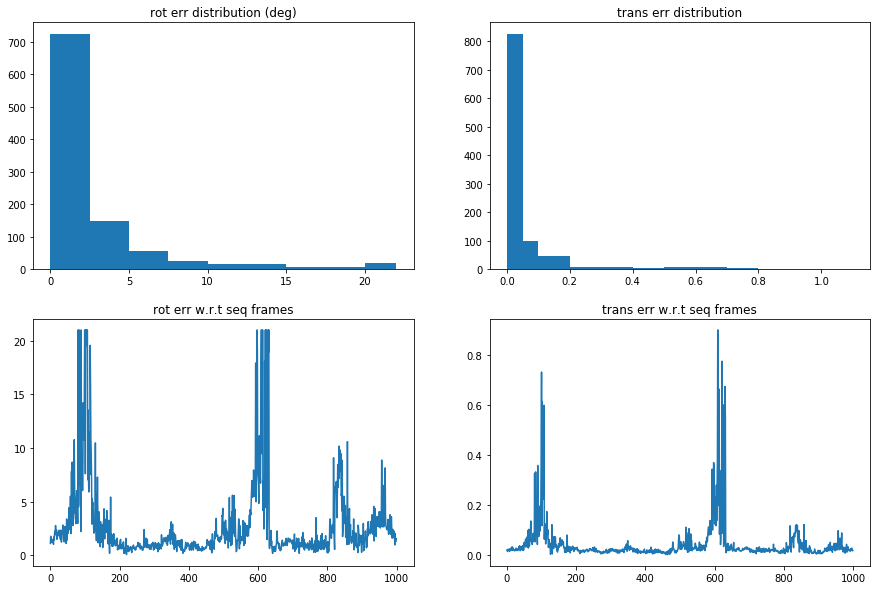

In [20]:
from sklearn.metrics.pairwise import cosine_similarity as cos_sim
from evaluator.basic_metric import rel_rot_angle, rel_distance
import core_3dv.camera_operator as cam_opt

x_2d = x_2d_coords_torch(top_k, frame_dim[0], frame_dim[1]).cuda()
x_2d = x_2d.view(top_k, -1, 2)
pnp_x_2d = cam_opt.x_2d_coords(h=out_dim[0], w=out_dim[1])

# evaluations (pose)
succ_count = 0
R_accs, t_accs, pnp_poses = [], [], []

# evluation (scene coordinate accuracy)
pred_scene_coord_acc = {
    '1cm': 0.0,
    '2.5cm': 0.0,
    '5cm': 0.0
}

for q_idx in tqdm(range(0, len(test_frames), 1)):
    
    # Step 1: find top-k neighbor frames of a given query frame ----------------------------------------------
    q_frame = test_frames[q_idx]
    q_set = SevenSceneManualDataset(base_dir=base_dir,
                                    seq_frame_list=[q_frame],
                                    transform=transform_func,
                                    fill_depth_holes=False,
                                    output_dim=(3, 192, 256),
                                    nsample_per_group=1)
    q_loader = DataLoader(q_set, batch_size=1, num_workers=0, shuffle=False)

    with torch.cuda.device(dev_id):
        with torch.no_grad():
            sample_dict = next(iter(q_loader))
            query_img = sample_dict['frames_img']
            query_ori_img = sample_dict['frames_ori_img']
            query_depth = sample_dict['frames_depth'].cuda()
            query_Tcw = sample_dict['frames_Tcw']
            ori_query_K = sample_dict['frames_K'].clone().cuda()
            
            query_img = query_img.squeeze(1)
            query_ori_img = query_ori_img.squeeze(1)
            query_depth = query_depth.squeeze(1)
            query_Tcw = query_Tcw.squeeze(1)
            ori_query_K = ori_query_K.squeeze(1)

            query_img, query_X_world, valid_mask, query_ori_img, scene_center, query_Tcw, query_K, rand_R = \
                preprocess_query(query_img, query_depth, query_ori_img, query_Tcw, ori_query_K, scene_center, rand_R, out_dim)
            seq_feat = vlad_db.forward(query_img)

    # determine top-K
    n_feat = seq_feat.shape[1]

    scene_feats = retrival_scene_feats
    n_scenes = len(scene_feats)
    
    dist = [cos_sim(seq_feat, scene_feats[idx]) for idx in range(n_scenes)]
    dist = np.asarray(dist).ravel()
    sorted_indices = np.argsort((1-dist))
    
    top_k_frames = [sampled_train_frames[idx] for idx in sorted_indices[:10]]
    
    # Step 2: build the scene representation ---------------------------------------------------------------
    scene_set = SevenSceneManualDataset(base_dir=base_dir,
                                        seq_frame_list=top_k_frames,
                                        transform=transform_func,
                                        fill_depth_holes=False,
                                        output_dim=(3, 192, 256),
                                        nsample_per_group=10)
    scene_loader = DataLoader(scene_set, batch_size=1, num_workers=0, shuffle=False)
    
    with torch.cuda.device(dev_id):
        with torch.no_grad():
            sample_dict = next(iter(scene_loader))
            scene_rgb = sample_dict['frames_img'].cuda()
            scene_depth = sample_dict['frames_depth'].cuda()
            scene_K = sample_dict['frames_K'].cuda()
            scene_Tcw = sample_dict['frames_Tcw']
            scene_ori_rgb = sample_dict['frames_ori_img'].cuda()
            scene_input, scene_ori_rgb, X_world, scene_valid_mask, scene_center, rand_R = \
                preprocess_scene(x_2d, scene_rgb, scene_depth, scene_K, scene_Tcw, scene_ori_rgb)

            model.eval()
            model.clear_scene_cache()
            for j in range(scene_input.shape[1] // 5):
                cur_scene_input = scene_input[:, j*5:(j+1)*5, ...]
                cur_scene_valid_mask = scene_valid_mask[:, j*5:(j+1)*5, ...]
                model.add_to_scene_cache(cur_scene_input, cur_scene_valid_mask)
            model.prepare_query()
    
    # Step 3: predict the query pose -------------------------------------------------------------------------
    q_set = SevenSceneManualDataset(base_dir=base_dir,
                                    seq_frame_list=[q_frame],
                                    transform=transform_func,
                                    fill_depth_holes=False,
                                    output_dim=(3, 192, 256),
                                    nsample_per_group=1)
    q_loader = DataLoader(q_set, batch_size=1, num_workers=0, shuffle=False)
    
    # predict scene coordinate 'pred_X_world'
    with torch.cuda.device(dev_id):
        with torch.no_grad():
            sample_dict = next(iter(q_loader))
            query_img = sample_dict['frames_img']
            query_ori_img = sample_dict['frames_ori_img']
            query_depth = sample_dict['frames_depth'].cuda()
            query_Tcw = sample_dict['frames_Tcw']
            ori_query_K = sample_dict['frames_K'].clone().cuda()
            
            query_img = query_img.squeeze(1)
            query_ori_img = query_ori_img.squeeze(1)
            query_depth = query_depth.squeeze(1)
            query_Tcw = query_Tcw.squeeze(1)
            ori_query_K = ori_query_K.squeeze(1)

            query_img, query_X_world, valid_mask, query_ori_img, scene_center, query_Tcw, query_K, rand_R = \
                preprocess_query(query_img, query_depth, query_ori_img, query_Tcw, ori_query_K, scene_center, rand_R, out_dim)

            pred_X_world, _, _ = model.query_forward(query_img)
    
    # compute pose by pnp and evaluate with ground-truth pose 'query_Tcw' 
    R_acc, t_acc, pnp_pose, _ = compute_pose_lm_pnp(query_Tcw, 
                                                    pred_X_world[-1],
                                                    rand_R, 
                                                    scene_center, 
                                                    query_K,
                                                    pnp_x_2d,
                                                    repro_thres=repro_thres)

    
    if R_acc >= 180.0:
        R_acc -= 360.0
        if R_acc < 0.0:
            R_acc *= -1.0
    
    if R_acc < 5.0 and t_acc < 0.05:
        succ_count += 1
        
    R_accs.append(R_acc)
    t_accs.append(t_acc)
    pnp_poses.append(pnp_pose)
    
    # measure the scene coordinate accuracy
    pred_scene_coord_acc['5cm'] += compute_accuracy(pred_X_world[4], query_X_world[4], valid_mask[4], 0.5)
    pred_scene_coord_acc['2.5cm'] += compute_accuracy(pred_X_world[4], query_X_world[4], valid_mask[4], 0.25)
    pred_scene_coord_acc['1cm'] += compute_accuracy(pred_X_world[4], query_X_world[4], valid_mask[4], 0.1)
    
# print statistic info.
total = len(test_frames)/1
print('# eval (5 deg, 5cm):')
print('total:', total, '   rot<5.0 & trans<0.05:', succ_count)
print('rot<5.0 & trans<0.05 ratio:', succ_count / total)

print('# eval (median):')
R_accs_np = np.array(R_accs)
R_accs_np[R_accs_np > 20.0] = 21.0
t_accs_np = np.array(t_accs)
t_accs_np[t_accs_np > 1.0] = 1.05
print('rot median:', np.median(R_accs_np), '   trans median:', np.median(t_accs_np))

print('# eval (avg. scene coordinate accuracy)')
print(' 5cm:', (pred_scene_coord_acc['5cm'] / total).item(), 
      ' 2.5cm:', (pred_scene_coord_acc['2.5cm'] / total).item(), 
      ' 1cm:', (pred_scene_coord_acc['1cm'] / total).item())

# plot error distribution
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0, 0].hist(R_accs_np, bins=(0, 2.5, 5, 7.5, 10, 15, 20, 22))
ax[0, 0].set_title('rot err distribution (deg)')

ax[0, 1].hist(t_accs_np, bins=(0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 1.0, 1.1))
ax[0, 1].set_title('trans err distribution')

ax[1, 0].plot(np.arange(0, total), R_accs_np)
ax[1, 0].set_title('rot err w.r.t seq frames')

ax[1, 1].plot(np.arange(0, total), t_accs_np)
ax[1, 1].set_title('trans err w.r.t seq frames')
plt.show()